# Analysis of Contract Awards in investment project financing

### Introduction
This dataset includes all contract awards financed by The World Bank under Investment Project Financing (IPF) operations.

### Source
https://financesone.worldbank.org/contract-awards-in-investment-project-financing/DS00005



In [53]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet


colors = sns.color_palette('husl')

## Data

In [2]:
gdp_df = pd.read_csv('data/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_31631.csv', skiprows=4)


columns_to_keep = ['Country Name', 'Country Code'] + [str(year) for year in range(2015, 2024)]
gdp_df = gdp_df[columns_to_keep]

gdp_df.head()

,Country Name,Country Code,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,-0.623626,1.719625,7.048533,2.381730,-2.302836,-23.982581,27.639357,10.458317,NaN
1,Africa Eastern and Southern,AFE,3.011572,2.183581,2.651400,2.681718,2.189259,-2.780379,4.497380,3.554422,2.622310
2,Afghanistan,AFG,1.451315,2.260314,2.647003,1.189228,3.911603,-2.351101,-20.738839,-6.240172,NaN
3,Africa Western and Central,AFW,2.813979,0.141489,2.284961,2.842645,3.222029,-1.004417,3.994854,3.784486,3.342776
4,Angola,AGO,0.943572,-2.580111,-0.147150,-1.316362,-0.702273,-5.638215,1.199211,3.045403,0.856001


In [3]:
contract_awards_df = pd.read_csv('data/contract_awards_in_investment_project_financing_09-10-2024.csv')
contract_awards_df.head()

,As of Date,Fiscal Year,Region,Borrower Country / Economy,Borrower Country / Economy Code,Project ID,Project Name,Project Global Practice,Procurement Category,Procurement Method,WB Contract Number,Contract Description,Borrower Contract Reference Number,Contract Signing Date,Supplier ID,Supplier,Supplier Country / Economy,Supplier Country / Economy Code,Supplier Contract Amount (USD),Review type
0,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Civil Works,Request for Bids,1621166,Abpashak River Bank Protection Scheme in Gresh...,MEW-REF-QR501-LOT1,22-Jan-2020,413420.0,BRIGHT PEARL CONST.CO,Afghanistan,AF,1355819.28,Post
1,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P125597,Kabul Municipal Development Program,"Transportation;Water, Sanitation and Waste Man...",Civil Works,Request for Bids,1632271,"Upgrading Infrastructure of Gozar 24, Dis. 12 ...",KMDP/W-94/U,21-Jan-2020,491163.0,"HIKMATULLAH KHAN NASIR ROAD, BUILDING & CONSTR...",Afghanistan,AF,649856.99,Post
2,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Goods,Request for Bids,1625013,Supply and Installation of Snow Pack Analyzers...,MEW-REF-G246,21-Jan-2020,427383.0,ASCENT AFG GROUP OF CO CONSTRUCTION & ENGINEERING,Afghanistan,AF,137725.00,Post
3,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P122235,AF Irrigation Restoration and Development Project,"Agriculture, Fishing and Forestry",Goods,Request for Bids,1625013,Supply and Installation of Snow Pack Analyzers...,MEW-REF-G246,21-Jan-2020,450443.0,RK ENGINEERING CORPORATION,India,IN,137725.00,Post
4,09-Oct-2024,2020,SOUTH ASIA,Afghanistan,AF,P125597,Kabul Municipal Development Program,"Transportation;Water, Sanitation and Waste Man...",Civil Works,Request for Bids,1617803,Upgrading Infrastructure of Tapa e Karte Naw T...,KMDP/W-100/T,21-Jan-2020,490859.0,AFGHAN BUILDERS CONSORTIUM,Afghanistan,AF,649219.82,Post


In [4]:
#converting to date time objects
contract_awards_df['Contract Signing Date'] = pd.to_datetime(contract_awards_df['Contract Signing Date'])
contract_awards_df['Year'] = contract_awards_df['Contract Signing Date'].dt.year

In [5]:
contract_awards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250994 entries, 0 to 250993
Data columns (total 21 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   As of Date                          250994 non-null  object        
 1   Fiscal Year                         250994 non-null  int64         
 2   Region                              250994 non-null  object        
 3   Borrower Country / Economy          250994 non-null  object        
 4   Borrower Country / Economy Code     246741 non-null  object        
 5   Project ID                          250994 non-null  object        
 6   Project Name                        250994 non-null  object        
 7   Project Global Practice             250340 non-null  object        
 8   Procurement Category                250994 non-null  object        
 9   Procurement Method                  250986 non-null  object        
 10  WB Contr

In [6]:
grouped_df = contract_awards_df.groupby(by = ['Project ID', 'WB Contract Number'])['Supplier Contract Amount (USD)'].sum().reset_index()
display(grouped_df)

,Project ID,WB Contract Number,Supplier Contract Amount (USD)
0,P050529,1540714,97000.00
1,P050529,1541294,80236.13
2,P050529,1541332,79969.00
3,P055120,1545554,901914.00
4,P064836,1545100,4293699.78
...,...,...,...
242435,P507066,1793773,48051.81
242436,P507066,1794892,14257.30
242437,P507066,1795803,1221688.96
242438,P507066,1796335,469908.62


In [7]:
new_rows = []
for index, row in contract_awards_df.iterrows():
    if ';' not in str(row['Project Global Practice']):
        new_rows.append(row)
        continue
    practices = str(row['Project Global Practice']).split(';')
    for practice in practices:
        new_row = row.copy()
        new_row['Project Global Practice'] = practice.strip()
        new_rows.append(new_row)

sorted_df = pd.DataFrame(new_rows)

In [8]:
sorted_df['Project Global Practice'].value_counts().head(20)

Agriculture, Fishing and Forestry              97805
Public Administration                          63206
Industry, Trade and Services                   57381
Social Protection                              45651
Water, Sanitation and Waste Management         42964
Education                                      39624
Transportation                                 35993
Health                                         35544
Information and Communications Technologies    31531
Energy and Extractives                         18119
Financial Sector                                6644
Name: Project Global Practice, dtype: int64

# Borrower Country Analysis

In [9]:
total_sum_per_country = contract_awards_df.groupby('Borrower Country / Economy')['Supplier Contract Amount (USD)'].sum().reset_index().sort_values('Supplier Contract Amount (USD)', ascending = False).reset_index(drop=True)
total_sum_per_country['Supplier Contract Amount (USD)'] = (total_sum_per_country['Supplier Contract Amount (USD)'] / 1000000000).round(2)
total_sum_per_country.columns = ['Country', 'Total Contract Amount (Billion USD)']
display(total_sum_per_country)

,Country,Total Contract Amount (Billion USD)
0,India,13.25
1,Pakistan,6.63
2,Bangladesh,5.72
3,China,5.11
4,Western and Central Africa,4.66
...,...,...
148,"Yemen, Republic of",0.00
149,Mauritius,0.00
150,Multi-Regional,0.00
151,South East Asia,0.00


In [10]:
total_sum_per_region = contract_awards_df.groupby('Region')['Supplier Contract Amount (USD)'].sum().reset_index().sort_values('Supplier Contract Amount (USD)', ascending = False).reset_index(drop=True)
total_sum_per_region['Supplier Contract Amount (USD)'] = (total_sum_per_region['Supplier Contract Amount (USD)'] / 1000000000).round(2)
total_sum_per_region.columns = ['Region', 'Total Contract Amount (Billion USD)']
display(total_sum_per_region)

,Region,Total Contract Amount (Billion USD)
0,SOUTH ASIA,30.17
1,Eastern and Southern Africa,27.76
2,Western and Central Africa,21.84
3,EUROPE AND CENTRAL ASIA,18.97
4,EAST ASIA AND PACIFIC,15.71
5,LATIN AMERICA AND CARIBBEAN,10.74
6,MIDDLE EAST AND NORTH AFRICA,6.48
7,AFRICA,0.01
8,OTHER,0.00


# Borrower Country Analysis

In [11]:

# Create a df for top 5 top borrowing countries
df_countries = sorted_df.groupby('Borrower Country / Economy')['Supplier Contract Amount (USD)'].sum().reset_index()

df_countries = df_countries.sort_values(by='Supplier Contract Amount (USD)', ascending=False).reset_index(drop=True)
df_countries
df_top_countries = df_countries.sort_values('Supplier Contract Amount (USD)', ascending=False).reset_index(drop=True).head(5)
df_top_countries

,Borrower Country / Economy,Supplier Contract Amount (USD)
0,India,2.044646e+10
1,Pakistan,1.845833e+10
2,Bangladesh,1.007276e+10
3,China,9.183416e+09
4,Western and Central Africa,8.398149e+09


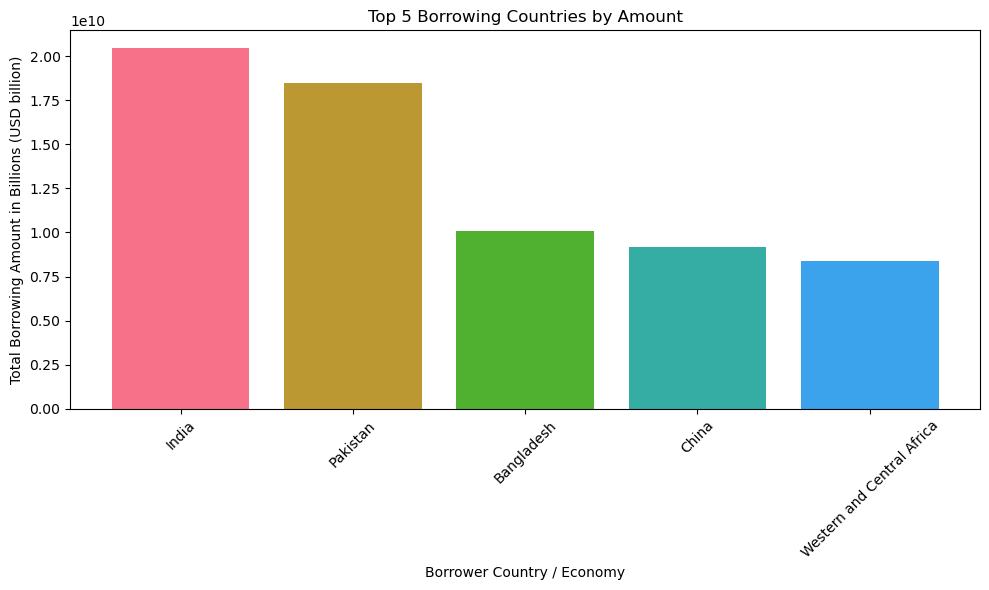

In [12]:

# Plot top 5 top borrowing countries
plt.figure(figsize=(10, 6))
plt.bar(df_top_countries['Borrower Country / Economy'], df_top_countries["Supplier Contract Amount (USD)"], color= colors)
plt.xlabel('Borrower Country / Economy')
plt.ylabel('Total Borrowing Amount in Billions (USD billion)')
plt.title('Top 5 Borrowing Countries by Amount')
plt.xticks(rotation=45)
top_countries = plt.tight_layout()
plt.tight_layout()
plt.show()

In [13]:

# create a pivot df to see the sum of Supplier Contract Amount (USD) by  Borrower Country / Economy by year
pivot_df = pd.pivot_table(sorted_df, values='Supplier Contract Amount (USD)', index='Fiscal Year', columns='Borrower Country / Economy', aggfunc='sum')
pivot_df = pivot_df.sort_values(by=list(pivot_df.columns), ascending=False)
pivot_df

Borrower Country / Economy,Afghanistan,Africa,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Belize,...,Uzbekistan,Vanuatu,Vietnam,West Bank and Gaza,Western Balkans,Western and Central Africa,World,"Yemen, Republic of",Zambia,Zimbabwe
Fiscal Year,,,,,,,,,,,,,,,,,,,,,
2019,8.758000e+08,100678.13,6.667323e+07,1.049747e+08,3.779283e+08,5.858146e+07,2.254262e+07,1.149102e+09,3.245993e+07,6180336.88,...,2.193787e+08,44913326.68,9.757706e+08,15254055.21,48518.73,6.437788e+08,83960.00,NaN,1.024030e+08,3550445.76
2017,5.344141e+08,19568696.32,2.103315e+08,3.720866e+07,2.427006e+08,9.063492e+07,2.184883e+08,1.507886e+09,4.062079e+08,10216284.17,...,2.352484e+08,70029328.00,3.517336e+08,35398166.14,59520.50,6.206109e+08,592821.48,NaN,1.482779e+08,10731859.49
2020,3.453970e+08,NaN,1.848846e+08,2.366087e+08,2.373736e+08,6.136945e+07,6.585225e+06,1.623993e+09,4.790025e+07,3268882.79,...,3.809302e+08,57317398.64,1.279670e+09,18330786.38,5962839.53,6.126823e+08,224256.00,NaN,1.358987e+08,1816621.56
2021,3.181813e+08,NaN,1.041673e+08,1.628691e+08,9.876294e+07,9.090263e+07,6.374801e+07,1.119814e+09,2.354514e+08,3314006.45,...,2.244402e+08,69865438.03,1.506563e+09,24386434.32,2850109.54,1.096503e+09,716936.89,NaN,6.168675e+07,2657108.07
2018,3.028574e+08,4249712.06,5.885424e+07,1.552506e+08,8.263513e+08,5.076940e+07,9.029696e+07,1.133270e+09,6.222263e+06,3288582.49,...,6.081184e+07,23068073.90,3.589358e+08,6290217.49,15389420.02,3.352684e+08,618831.00,NaN,7.461990e+07,3222453.87
2022,3.086722e+06,NaN,6.463400e+07,3.670816e+08,1.472325e+09,1.164432e+08,3.158203e+08,1.756489e+09,6.519522e+07,2120892.25,...,4.313955e+08,18981222.88,1.832117e+09,51580461.81,8152235.68,1.309182e+09,942648.28,89250.00,1.025601e+08,3189529.35
2024,5.592236e+05,NaN,2.091663e+07,1.009489e+08,9.843783e+07,8.980331e+07,1.058099e+08,1.017068e+09,NaN,5882549.25,...,3.381416e+08,17940418.40,9.816837e+07,66371856.90,98169146.08,2.345674e+09,134733.29,263956.05,1.023641e+08,1145092.43
2025,6.722842e+04,NaN,1.268951e+06,1.279878e+07,1.225665e+07,2.367349e+06,1.936315e+05,1.038341e+07,NaN,536059.78,...,5.955394e+07,299851.02,1.083618e+07,9563156.40,6572500.06,1.065983e+08,NaN,NaN,1.901086e+06,34698.00
2023,NaN,NaN,1.137420e+08,1.424339e+08,5.937037e+08,1.000431e+08,1.338070e+08,7.547567e+08,1.960000e+04,1802120.78,...,4.810522e+08,54896081.61,6.325398e+08,39197795.19,22607442.26,1.327851e+09,972281.98,312895.51,1.556280e+08,1481013.21


In [14]:

contract_amount = pd.pivot_table(sorted_df, values='Supplier Contract Amount (USD)', index=['Borrower Country / Economy', 'Fiscal Year'], aggfunc='sum')
contract_amount

Supplier Contract Amount (USD)
Borrower Country / Economy Fiscal Year                                
Afghanistan                2017                           5.344141e+08
                           2018                           3.028574e+08
                           2019                           8.758000e+08
                           2020                           3.453970e+08
                           2021                           3.181813e+08
...                                                                ...
Zimbabwe                   2021                           2.657108e+06
                           2022                           3.189529e+06
                           2023                           1.481013e+06
                           2024                           1.145092e+06
                           2025                           3.469800e+04

[1243 rows x 1 columns]

In [15]:
supplier_count = pd.pivot_table(sorted_df, values='Supplier ID', index=['Borrower Country / Economy', 'Fiscal Year',], aggfunc='count')
supplier_count

Supplier ID
Borrower Country / Economy Fiscal Year             
Afghanistan                2017                 329
                           2018                 286
                           2019                 508
                           2020                 611
                           2021                1225
...                                             ...
Zimbabwe                   2021                  39
                           2022                  67
                           2023                  40
                           2024                  13
                           2025                   1

[1243 rows x 1 columns]

In [16]:
merged_df = pd.merge(contract_amount, supplier_count, how='left', on=['Borrower Country / Economy','Fiscal Year'])
merged_df.reset_index(inplace=True)
merged_df

,Borrower Country / Economy,Fiscal Year,Supplier Contract Amount (USD),Supplier ID
0,Afghanistan,2017,5.344141e+08,329
1,Afghanistan,2018,3.028574e+08,286
2,Afghanistan,2019,8.758000e+08,508
3,Afghanistan,2020,3.453970e+08,611
4,Afghanistan,2021,3.181813e+08,1225
...,...,...,...,...
1238,Zimbabwe,2021,2.657108e+06,39
1239,Zimbabwe,2022,3.189529e+06,67
1240,Zimbabwe,2023,1.481013e+06,40
1241,Zimbabwe,2024,1.145092e+06,13


# Afganistan Analysis

In [17]:

Afghanistan_df = merged_df[merged_df['Borrower Country / Economy'] == 'Afghanistan'].set_index('Fiscal Year',drop=True)
Afghanistan_df.drop(columns=['Borrower Country / Economy'], inplace=True)
Afghanistan_df.reset_index(inplace=True)
Afghanistan_df=Afghanistan_df.rename(columns={'Supplier Contract Amount (USD)':'Spending Amount','Supplier ID':'Project Count'})
Afghanistan_df

,Fiscal Year,Spending Amount,Project Count
0,2017,5.344141e+08,329
1,2018,3.028574e+08,286
2,2019,8.758000e+08,508
3,2020,3.453970e+08,611
4,2021,3.181813e+08,1225
5,2022,3.086722e+06,54
6,2024,5.592236e+05,16
7,2025,6.722842e+04,8


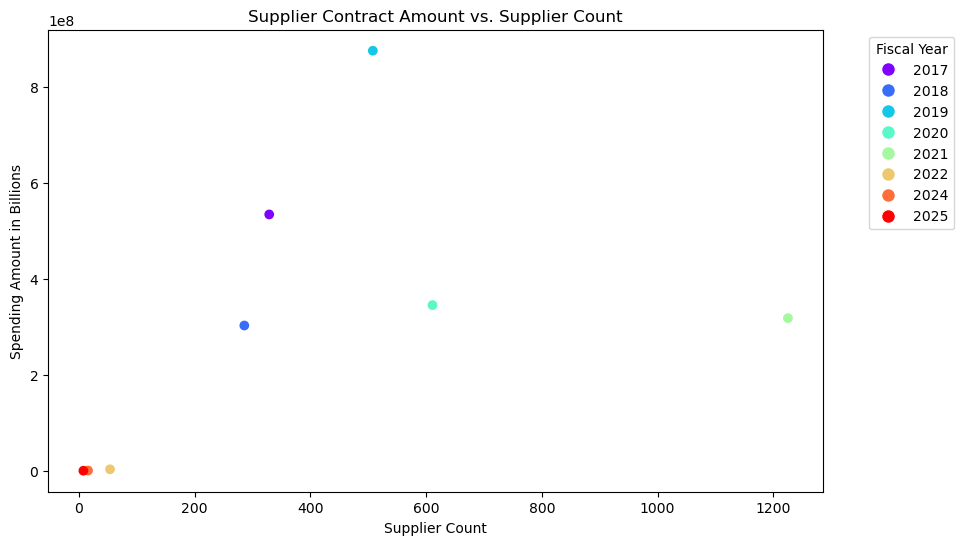

In [47]:
import numpy as np
import matplotlib.cm as cm

# Create a color map
colors = cm.rainbow(np.linspace(0, 1, len(Afghanistan_df)))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(Afghanistan_df['Project Count'], Afghanistan_df['Spending Amount'], color=colors)
plt.xlabel('Supplier Count')
plt.ylabel('Spending Amount in Billions')
plt.title('Supplier Contract Amount vs. Supplier Count')

# Create a legend for the years
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(Afghanistan_df))]
labels = Afghanistan_df['Fiscal Year'].astype(str).tolist()
plt.legend(handles, labels, title="Fiscal Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<Axes: xlabel='Fiscal Year'>

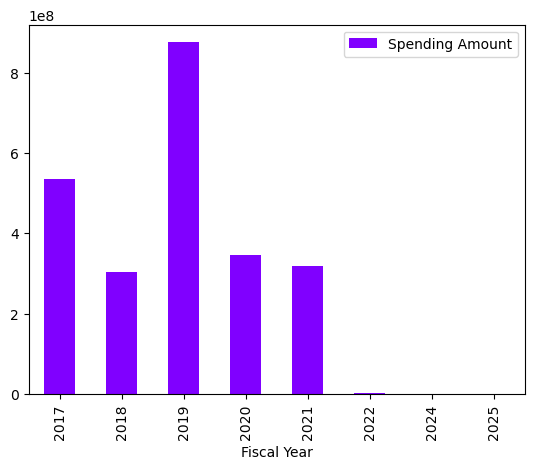

In [48]:
Afghanistan_reset = Afghanistan_df.reset_index(drop=True)
Afghanistan_reset.plot(kind='bar', x='Fiscal Year', y='Spending Amount', color= colors[0])


<Axes: xlabel='Fiscal Year'>

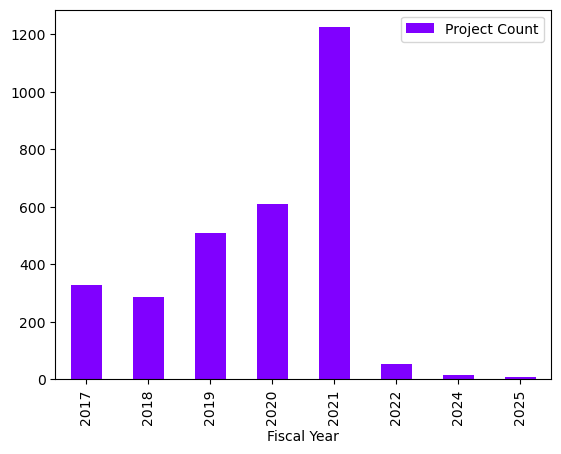

In [51]:
Afghanistan_reset.plot(kind='bar', x='Fiscal Year', y='Project Count', color= colors[0])


In [54]:
af_spending = Afghanistan_reset[['Fiscal Year','Spending Amount']]
af_spending['Fiscal Year'] = pd.to_datetime(af_spending['Fiscal Year'], format='%Y')
af_spending = af_spending.rename(columns={'Spending Amount':'y','Fiscal Year':'ds'})
af_spending

,ds,y
0,2017-01-01,5.344141e+08
1,2018-01-01,3.028574e+08
2,2019-01-01,8.758000e+08
3,2020-01-01,3.453970e+08
4,2021-01-01,3.181813e+08
5,2022-01-01,3.086722e+06
6,2024-01-01,5.592236e+05
7,2025-01-01,6.722842e+04


In [62]:
af_contracts= Afghanistan_reset[['Fiscal Year','Project Count']]
af_contracts['Fiscal Year'] = pd.to_datetime(af_contracts['Fiscal Year'], format='%Y')
af_contracts = af_contracts.rename(columns={'Project Count':'y','Fiscal Year':'ds'})
af_contracts

,ds,y
0,2017-01-01,329
1,2018-01-01,286
2,2019-01-01,508
3,2020-01-01,611
4,2021-01-01,1225
5,2022-01-01,54
6,2024-01-01,16
7,2025-01-01,8


20:24:34 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing


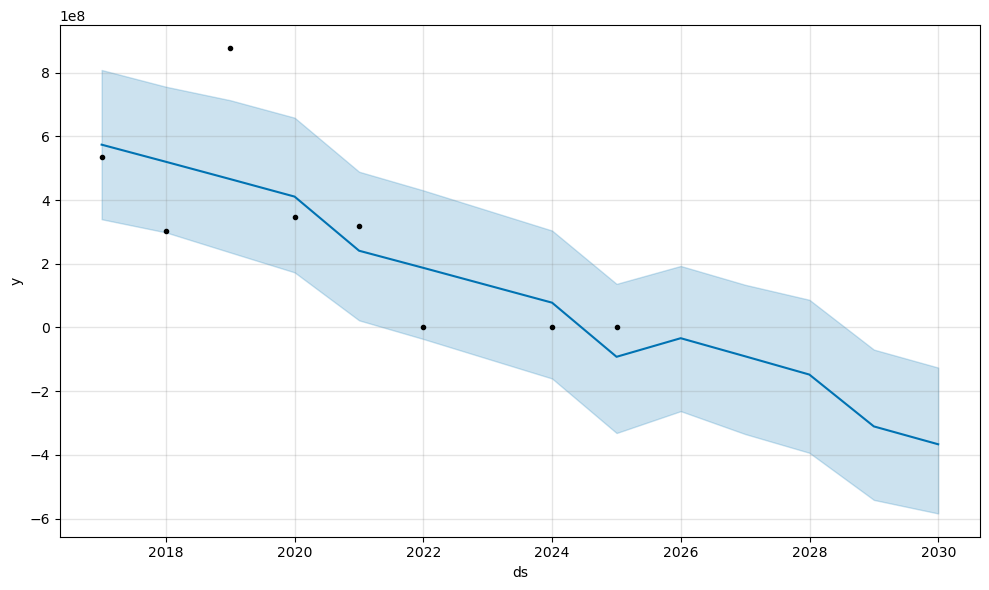

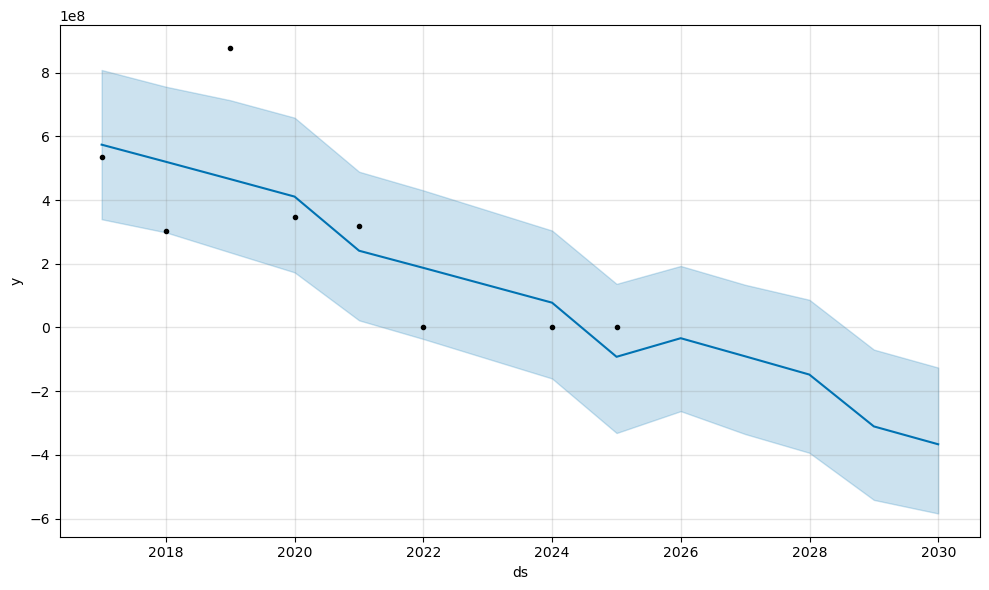

In [60]:
model_spending = Prophet()
model_spending.fit(af_spending)
future_spending = model_spending.make_future_dataframe(periods=5, freq='y')
future_spending
forecast_spending = model_spending.predict(future_spending)
model_spending.plot(forecast_spending)

20:25:22 - cmdstanpy - INFO - Chain [1] start processing
20:25:22 - cmdstanpy - INFO - Chain [1] done processing


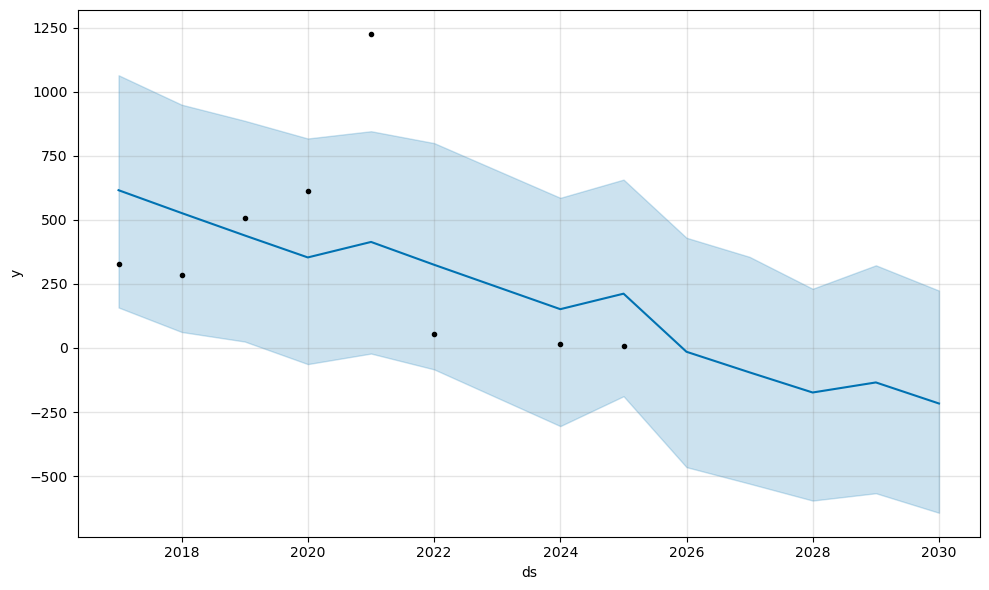

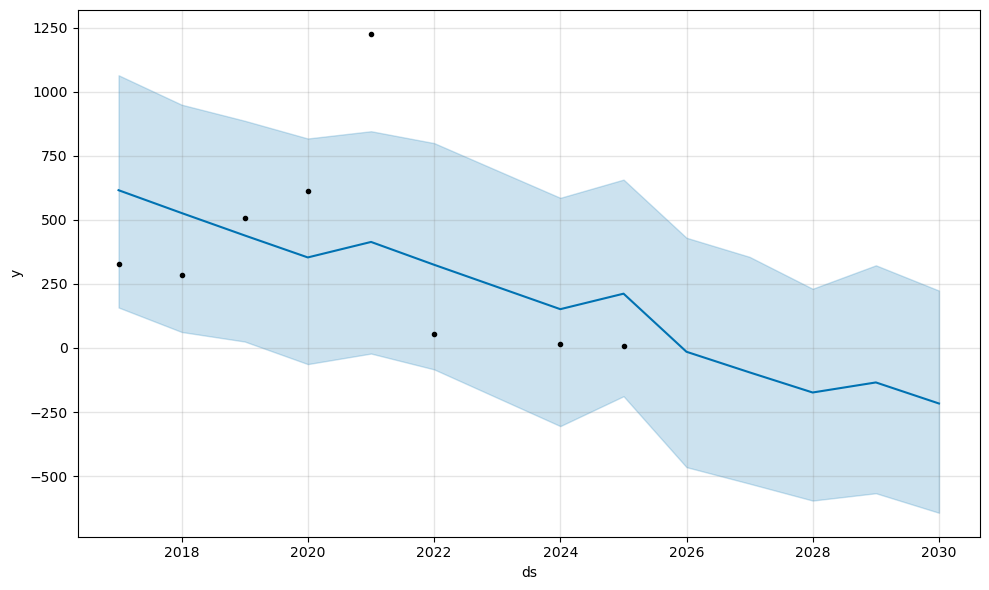

In [64]:

model_contracts = Prophet()
model_contracts.fit(af_contracts)
future_contracts = model_contracts.make_future_dataframe(periods=5, freq='y')
future_contracts
forecast_contracts = model_contracts.predict(future_contracts)
model_contracts.plot(forecast_contracts)

In [65]:

India_df = merged_df[merged_df['Borrower Country / Economy'] == 'India'].set_index('Fiscal Year',drop=True)
India_df.drop(columns=['Borrower Country / Economy'], inplace=True)
India_df.reset_index(inplace=True)
India_df=India_df.rename(columns={'Supplier Contract Amount (USD)':'Spending Amount','Supplier ID':'Supplier Count'})
India_df

,Fiscal Year,Spending Amount,Supplier Count
0,2017,3.263041e+09,4272
1,2018,4.128220e+09,5491
2,2019,2.514720e+09,9604
3,2020,3.690530e+09,10964
4,2021,3.080006e+09,14890
5,2022,2.090471e+09,9553
6,2023,9.581917e+08,7172
7,2024,6.127690e+08,5084
8,2025,1.085097e+08,260


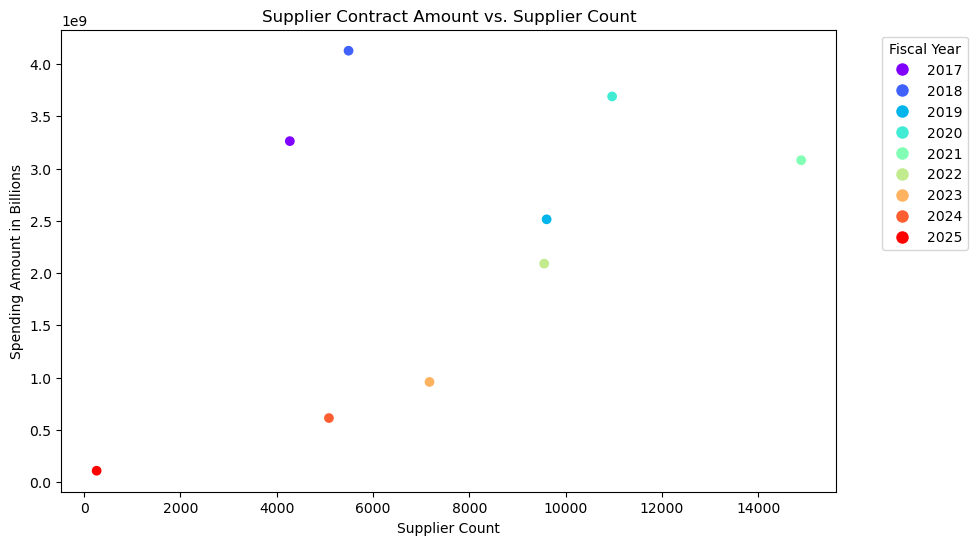

In [78]:

# Create a color map
colors = cm.rainbow(np.linspace(0, 1, len(India_df)))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(India_df['Supplier Count'], India_df['Spending Amount'], color=colors)
plt.xlabel('Supplier Count')
plt.ylabel('Spending Amount in Billions')
plt.title('Supplier Contract Amount vs. Supplier Count')

# Create a legend for the years
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(len(India_df))]
labels = India_df['Fiscal Year'].astype(str).tolist()
plt.legend(handles, labels, title="Fiscal Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<Axes: xlabel='Fiscal Year'>

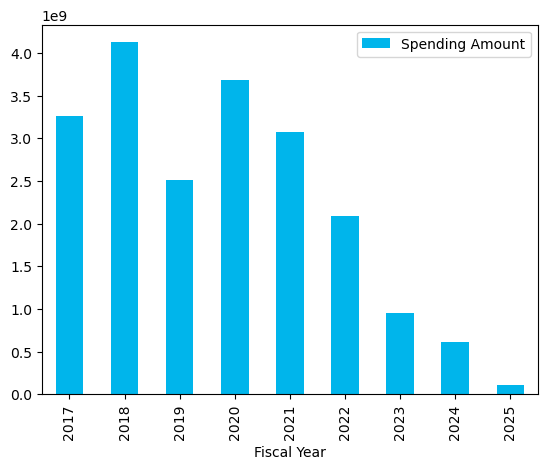

In [80]:
India_reset = India_df.reset_index(drop=True)
India_reset.plot(kind='bar', x='Fiscal Year', y='Spending Amount', color= colors[2])

<Axes: xlabel='Fiscal Year'>

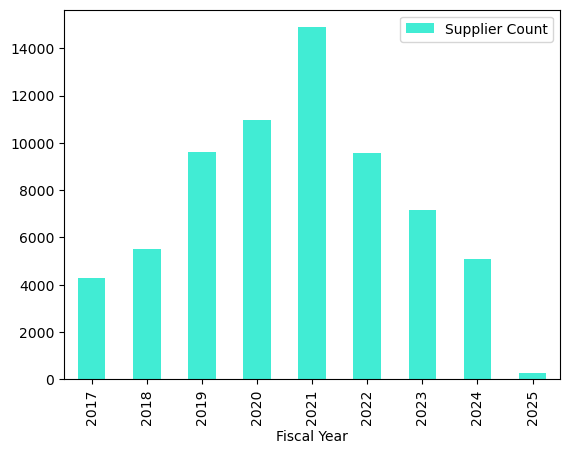

In [81]:
India_reset.plot(kind='bar', x='Fiscal Year', y='Supplier Count', color= colors[3])


In [71]:

India_spending = India_reset[['Fiscal Year','Spending Amount']]
India_spending['Fiscal Year'] = pd.to_datetime(India_spending['Fiscal Year'], format='%Y')
India_spending = India_spending.rename(columns={'Spending Amount':'y','Fiscal Year':'ds'})
India_spending

,ds,y
0,2017-01-01,3.263041e+09
1,2018-01-01,4.128220e+09
2,2019-01-01,2.514720e+09
3,2020-01-01,3.690530e+09
4,2021-01-01,3.080006e+09
5,2022-01-01,2.090471e+09
6,2023-01-01,9.581917e+08
7,2024-01-01,6.127690e+08
8,2025-01-01,1.085097e+08


In [72]:

India_contracts= India_reset[['Fiscal Year','Supplier Count']]
India_contracts['Fiscal Year'] = pd.to_datetime(India_contracts['Fiscal Year'], format='%Y')
India_contracts = India_contracts.rename(columns={'Supplier Count':'y','Fiscal Year':'ds'})
India_contracts

,ds,y
0,2017-01-01,4272
1,2018-01-01,5491
2,2019-01-01,9604
3,2020-01-01,10964
4,2021-01-01,14890
5,2022-01-01,9553
6,2023-01-01,7172
7,2024-01-01,5084
8,2025-01-01,260


20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing


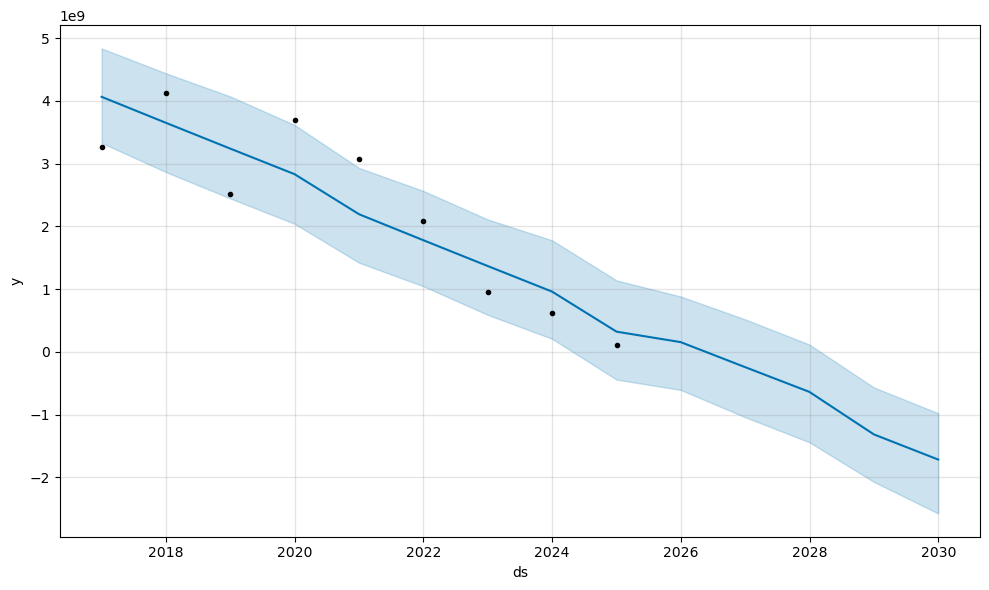

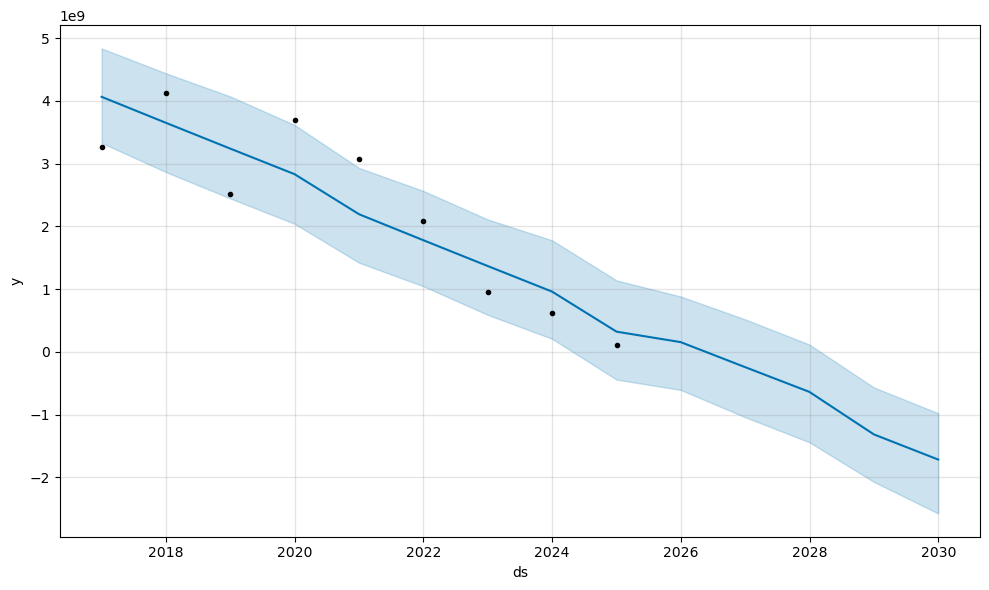

In [75]:

model_spending = Prophet()
model_spending.fit(India_spending)
future_spending = model_spending.make_future_dataframe(periods=5, freq='y')
future_spending
forecast_spending = model_spending.predict(future_spending)
model_spending.plot(forecast_spending)

20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] done processing


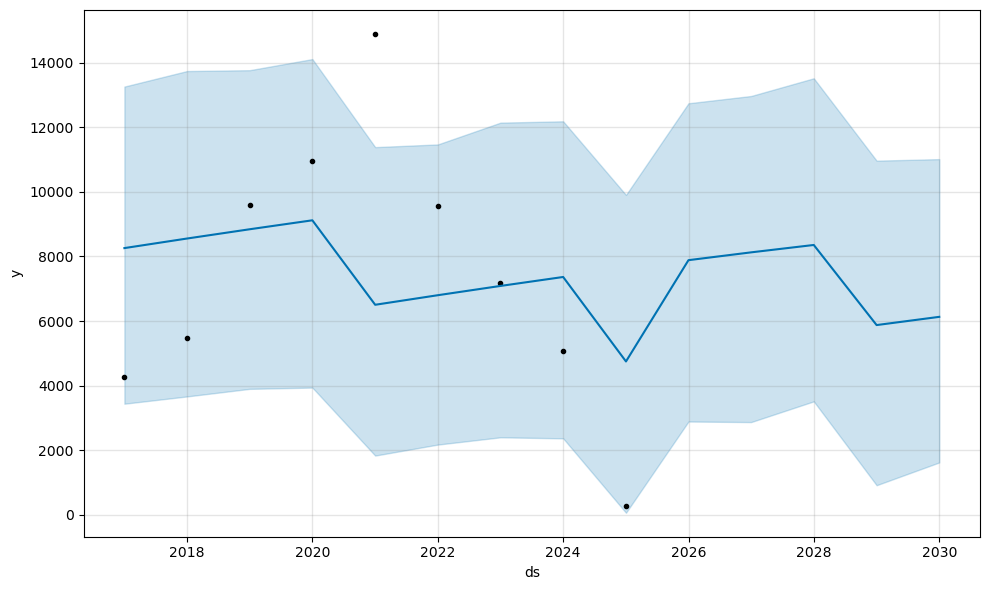

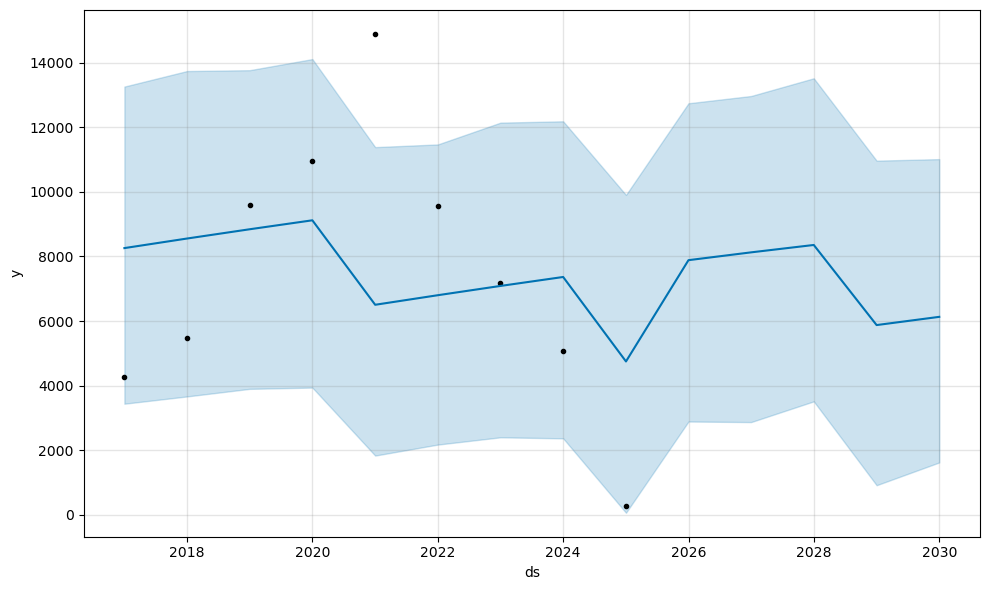

In [76]:
model_contracts = Prophet()
model_contracts.fit(India_contracts)
future_contracts = model_contracts.make_future_dataframe(periods=5, freq='y')
future_contracts
forecast_contracts = model_contracts.predict(future_contracts)
model_contracts.plot(forecast_contracts)

# Supplier Country Analysis

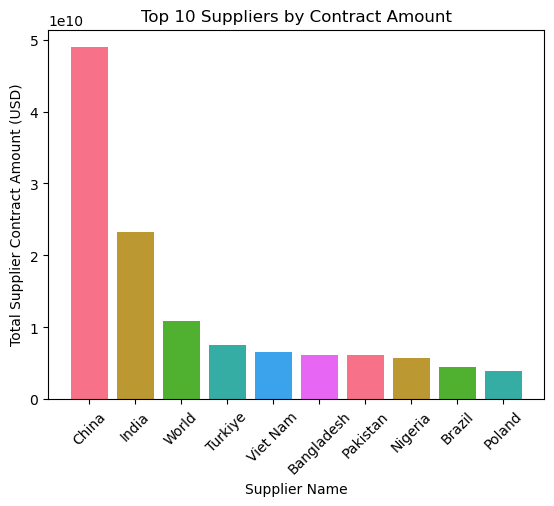

In [19]:
supplier_contract_country = sorted_df.groupby('Supplier Country / Economy')['Supplier Contract Amount (USD)'].sum().sort_values(ascending=False)

top_suppliers = supplier_contract_country.head(10)

plt.bar(top_suppliers.index, top_suppliers.values, color=colors)
plt.xlabel('Supplier Name')
plt.ylabel('Total Supplier Contract Amount (USD)')
plt.title('Top 10 Suppliers by Contract Amount')
plt.xticks(rotation=45)
plt.show()


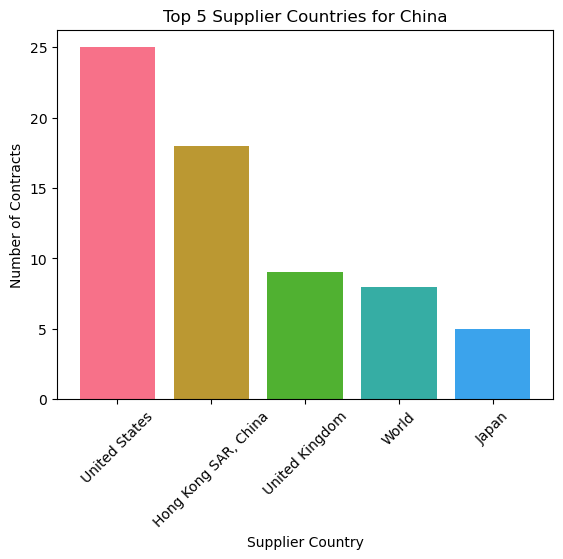

In [20]:
china_contracts = sorted_df[sorted_df['Borrower Country / Economy'] == 'China']

china_contracts = china_contracts[china_contracts['Supplier Country / Economy'] != 'China']

supplier_countries_china = china_contracts['Supplier Country / Economy'].value_counts().head(5)

supplier_countries_china

plt.bar(supplier_countries_china.index, supplier_countries_china.values, color = colors)
plt.title('Top 5 Supplier Countries for China')
plt.xlabel('Supplier Country')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()


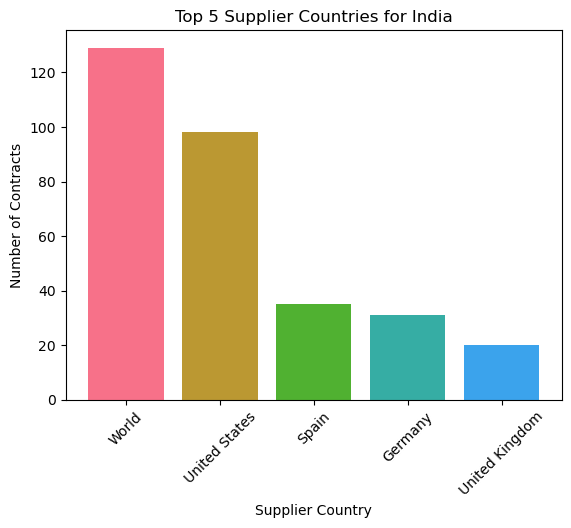

In [21]:
india_contracts = sorted_df[sorted_df['Borrower Country / Economy'] == 'India']

india_contracts = india_contracts[india_contracts['Supplier Country / Economy'] != 'India']

supplier_countries_india = india_contracts['Supplier Country / Economy'].value_counts().head(5)

plt.bar(supplier_countries_india.index, supplier_countries_india.values, color = colors)
plt.title('Top 5 Supplier Countries for India')
plt.xlabel('Supplier Country')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

# Contract Award Analysis

In [22]:
contract_awards_df['Contract Signing Date'] = pd.to_datetime(contract_awards_df['Contract Signing Date'])
contracts_over_time = contract_awards_df.groupby(contract_awards_df['Contract Signing Date'].dt.year)['Supplier Contract Amount (USD)'].sum()
print(contracts_over_time)

Contract Signing Date
2016    6.975246e+09
2017    1.516208e+10
2018    1.302945e+10
2019    1.476942e+10
2020    1.690782e+10
2021    2.083167e+10
2022    1.648783e+10
2023    1.707766e+10
2024    1.045169e+10
Name: Supplier Contract Amount (USD), dtype: float64


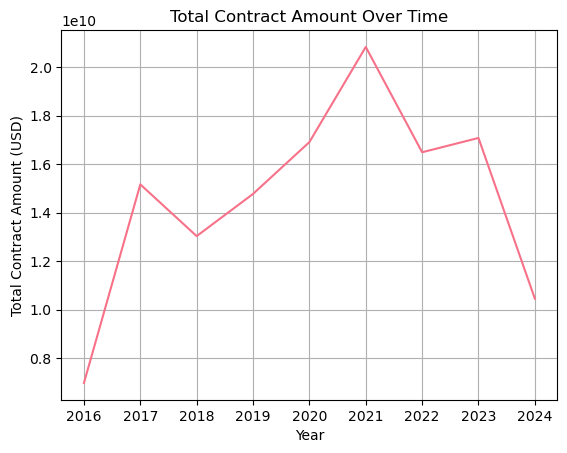

In [23]:
plt.plot(contracts_over_time.index, contracts_over_time.values, color = colors[0])
plt.title('Total Contract Amount Over Time')
plt.xlabel('Year')
plt.ylabel('Total Contract Amount (USD)')
plt.grid(True)
plt.show()

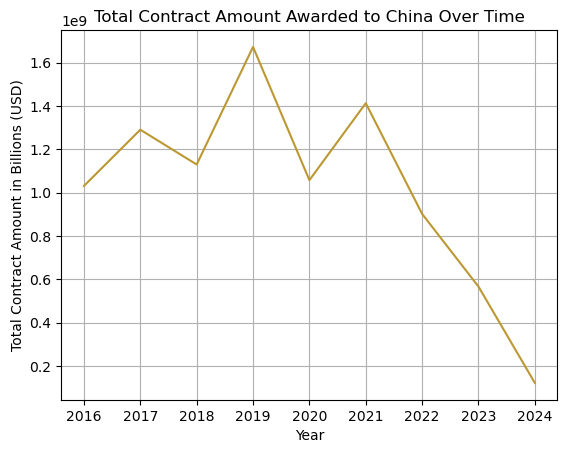

In [24]:
china_contracts = sorted_df[sorted_df['Borrower Country / Economy'] == 'China']

china_contracts_over_time = china_contracts.groupby(china_contracts['Contract Signing Date'].dt.year)['Supplier Contract Amount (USD)'].sum()

plt.plot(china_contracts_over_time.index, china_contracts_over_time.values, color = colors[1])
plt.title('Total Contract Amount Awarded to China Over Time')
plt.xlabel('Year')
plt.ylabel('Total Contract Amount in Billions (USD)')
plt.grid(True)
plt.show()

/var/folders/44/b8261lv57136y15mwmjzj7kc0000gn/T/ipykernel_82748/914453751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_contracts['Contract Signing Date'] = pd.to_datetime(india_contracts['Contract Signing Date'])


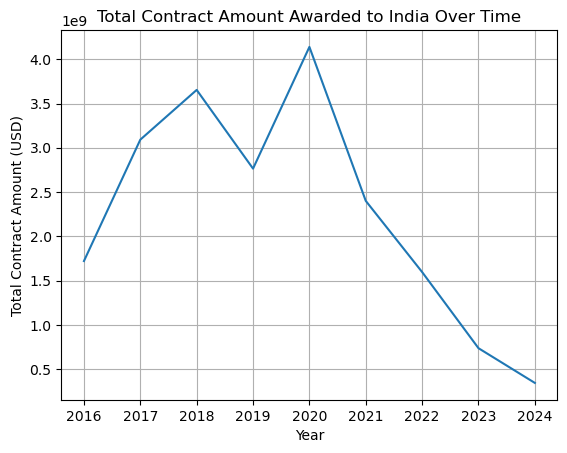

In [25]:

india_contracts = sorted_df[sorted_df['Borrower Country / Economy'] == 'India']

india_contracts['Contract Signing Date'] = pd.to_datetime(india_contracts['Contract Signing Date'])

india_contracts_over_time = india_contracts.groupby(india_contracts['Contract Signing Date'].dt.year)['Supplier Contract Amount (USD)'].sum()

plt.plot(india_contracts_over_time.index, india_contracts_over_time.values)
plt.title('Total Contract Amount Awarded to India Over Time')
plt.xlabel('Year')
plt.ylabel('Total Contract Amount (USD)')
plt.grid(True)
plt.show()

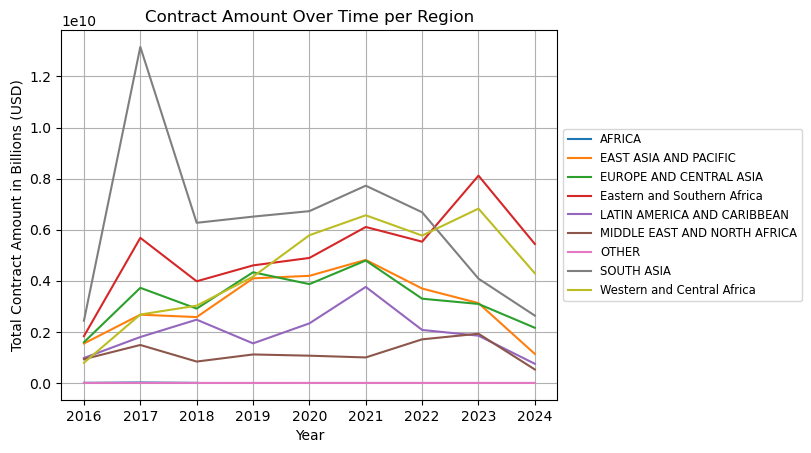

In [26]:
sorted_df['Contract Signing Date'] = pd.to_datetime(sorted_df['Contract Signing Date'])

region_contracts_over_time = sorted_df.groupby([sorted_df['Region'], sorted_df['Contract Signing Date'].dt.year])['Supplier Contract Amount (USD)'].sum().unstack()

#chatgpt and stackoverflow to the rescue for this, had to do this or else it graph by the year instead of region for some reason
for region in region_contracts_over_time.index:
    plt.plot(region_contracts_over_time.columns, region_contracts_over_time.loc[region], label=region)


plt.title('Contract Amount Over Time per Region')
plt.xlabel('Year')
plt.ylabel('Total Contract Amount in Billions (USD)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.show()

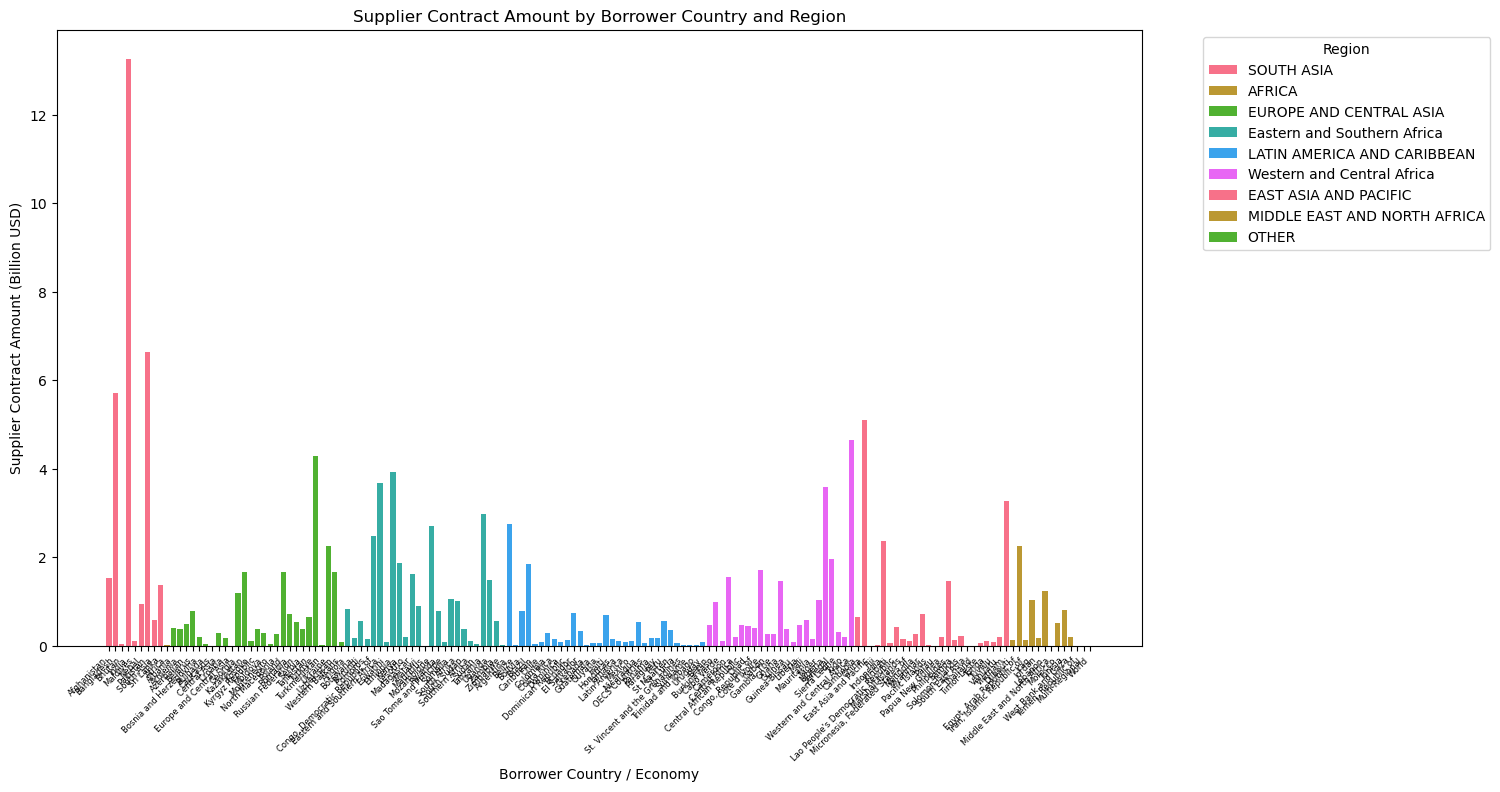

In [27]:
# Calculate the supplier contract amount in billions for each country
contract_awards_df['Supplier Contract Amount (Billion USD)'] = contract_awards_df['Supplier Contract Amount (USD)'] / 1e9

# Group by Borrower Country / Economy and Region
country_region_sum = contract_awards_df.groupby(['Borrower Country / Economy', 'Region'])['Supplier Contract Amount (Billion USD)'].sum().reset_index()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create a color palette for the regions
region_colors = {region: colors[i % len(colors)] for i, region in enumerate(country_region_sum['Region'].unique())}

# Plot the histogram
for region in country_region_sum['Region'].unique():
    subset = country_region_sum[country_region_sum['Region'] == region]
    plt.bar(subset['Borrower Country / Economy'], subset['Supplier Contract Amount (Billion USD)'], label=region, color=region_colors[region])

# Add labels and title
plt.xlabel('Borrower Country / Economy')
plt.ylabel('Supplier Contract Amount (Billion USD)')
plt.title('Supplier Contract Amount by Borrower Country and Region')
plt.xticks(rotation=45, fontsize=6, ha='right')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

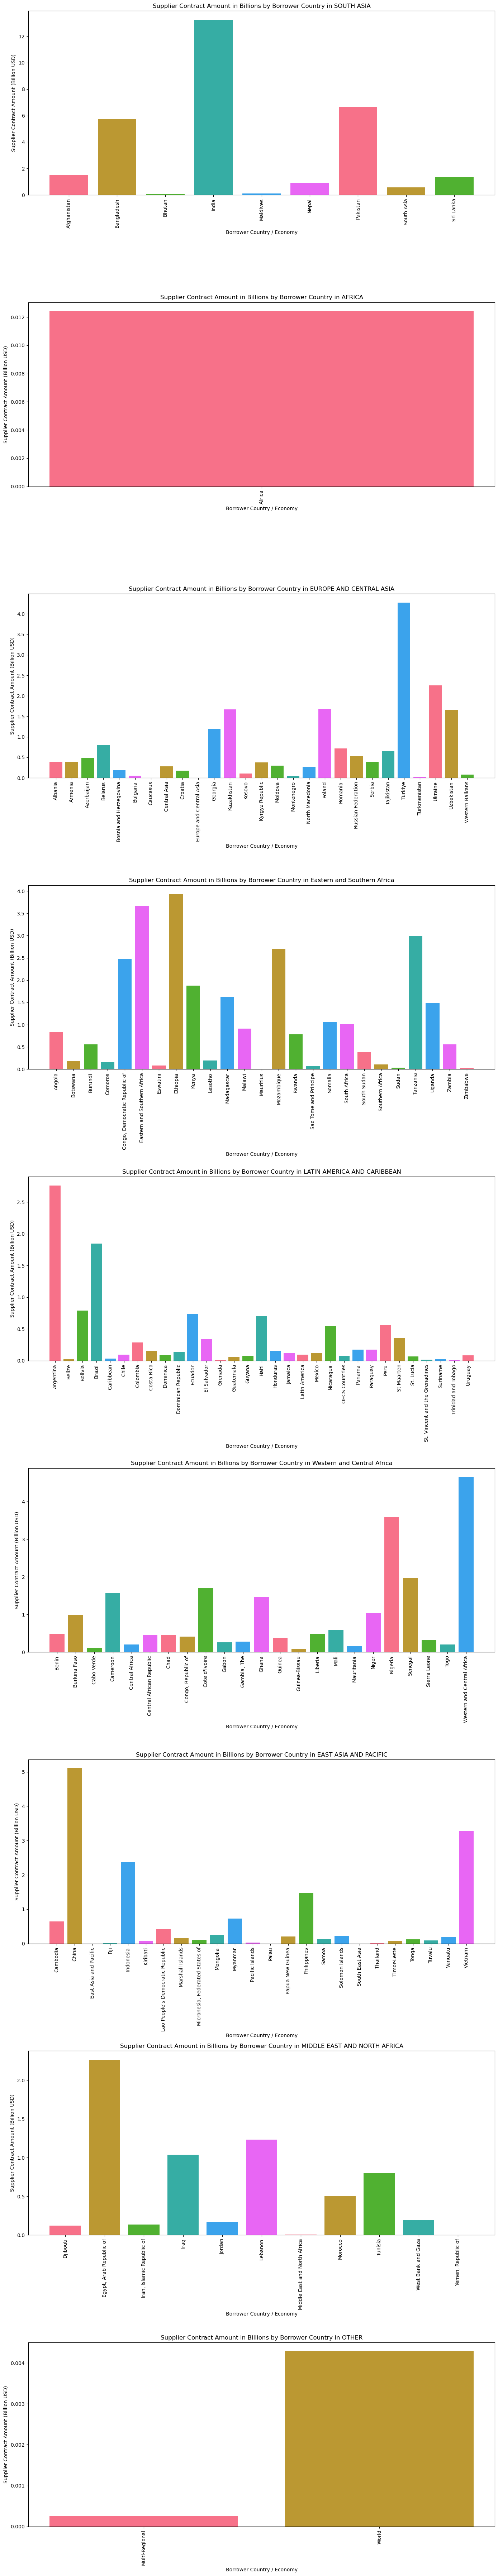

In [28]:
# Get the unique regions
unique_regions = country_region_sum['Region'].unique()

# Set up the figure size
plt.figure(figsize=(14, 8 * len(unique_regions)))

# Set up color palette
colors = sns.color_palette('husl')

# Loop through each region and create a subplot
for i, region in enumerate(unique_regions):
    plt.subplot(len(unique_regions), 1, i + 1)
    region_data = country_region_sum[country_region_sum['Region'] == region]
    plt.bar(region_data['Borrower Country / Economy'], region_data['Supplier Contract Amount (Billion USD)'], color=colors[:len(region_data)])
    plt.xticks(rotation=90)
    plt.title(f'Supplier Contract Amount in Billions by Borrower Country in {region}')
    plt.xlabel('Borrower Country / Economy')
    plt.ylabel('Supplier Contract Amount (Billion USD)')

plt.tight_layout()
plt.show()

# Procurment Method Analysis

<Axes: >

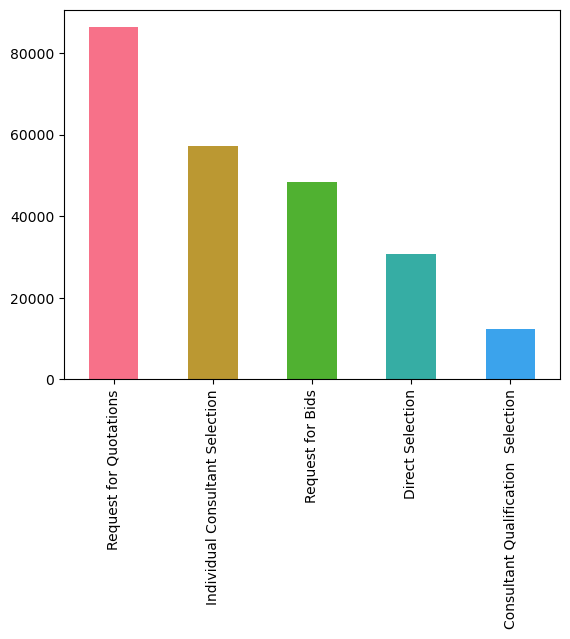

In [29]:


procurment_methods = contract_awards_df['Procurement Method'].value_counts().head(5)
procurment_methods.plot(kind='bar', color=colors)


# Project Global Practice Analysis

In [30]:
sorted_df['Project Global Practice'].value_counts().head(20)

Agriculture, Fishing and Forestry              97805
Public Administration                          63206
Industry, Trade and Services                   57381
Social Protection                              45651
Water, Sanitation and Waste Management         42964
Education                                      39624
Transportation                                 35993
Health                                         35544
Information and Communications Technologies    31531
Energy and Extractives                         18119
Financial Sector                                6644
Name: Project Global Practice, dtype: int64

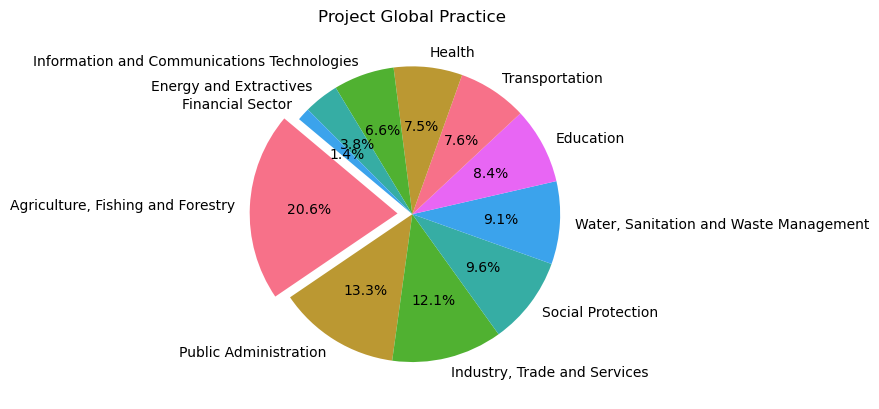

In [31]:

# Get the value counts for the 'Project Global Practice' column
practice_counts = sorted_df['Project Global Practice'].value_counts().head(20)
plt.pie(practice_counts,  labels = practice_counts.index, autopct='%1.1f%%', startangle=140, colors = colors, explode=[0.1 if i == 0 else 0 for i in range(len(practice_counts))])
plt.title('Project Global Practice')
plt.show()


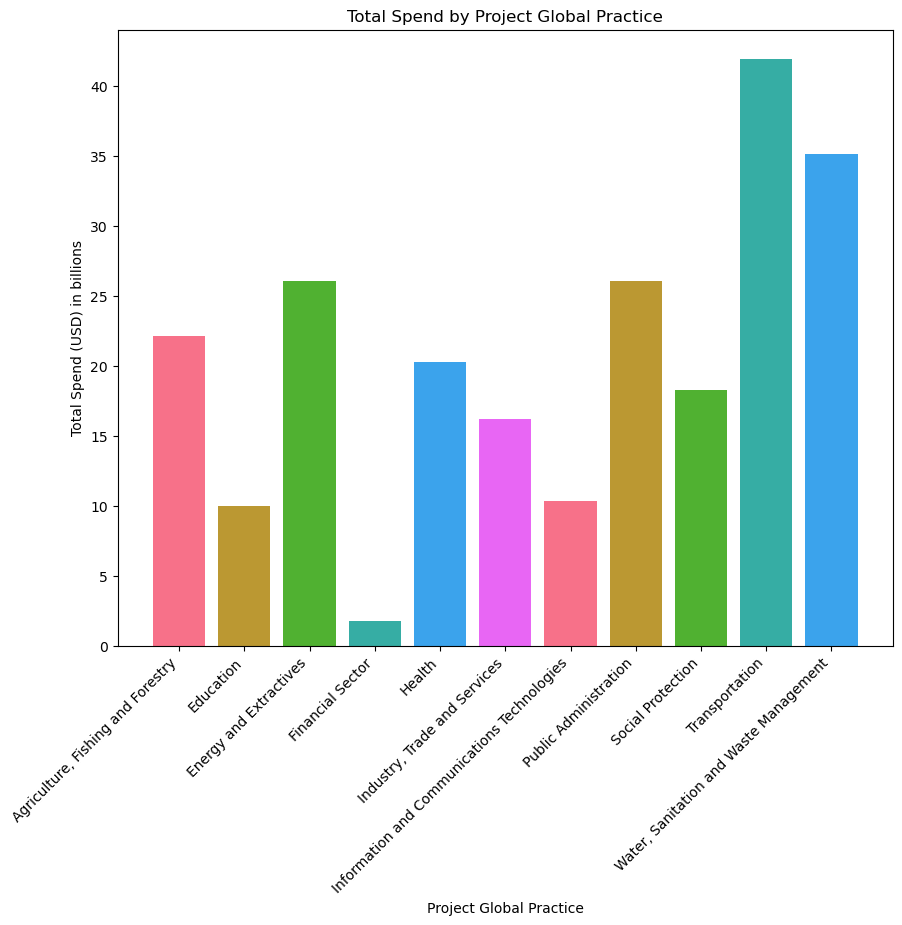

In [32]:

# Grouped by 'Project Global Practice' and sum the 'Supplier Contract Amount (USD)'
grouped_project_global_practice = sorted_df.groupby('Project Global Practice')['Supplier Contract Amount (USD)'].sum().reset_index()

grouped_project_global_practice['Supplier Contract Amount (USD)'] = grouped_project_global_practice['Supplier Contract Amount (USD)'] / 1000000000


# Plot the bar chart
plt.figure(figsize=(10, 8))
plt.bar(grouped_project_global_practice['Project Global Practice'], grouped_project_global_practice['Supplier Contract Amount (USD)'], color = colors)
plt.xlabel('Project Global Practice')
plt.ylabel('Total Spend (USD) in billions')
plt.title('Total Spend by Project Global Practice')
plt.xticks(rotation=45, ha='right')
plt.show()

# Procurement Category Analysis

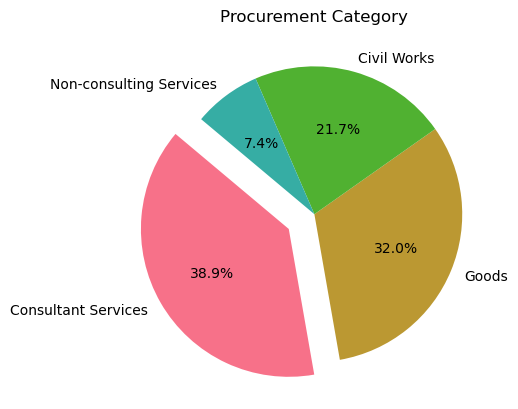

In [33]:
procurment_category_counts = contract_awards_df['Procurement Category'].value_counts().head(20)
plt.pie(procurment_category_counts,  labels = procurment_category_counts.index, autopct='%1.1f%%', startangle=140, colors = colors, explode= (0.2, 0, 0, 0))
plt.title('Procurement Category')
plt.show()

# Average GDP Growth by Region

In [34]:
# Read the CSV file
contract_awards_df = pd.read_csv('data/contract_awards_in_investment_project_financing_09-10-2024.csv')

# Group by 'Region' and aggregate 'Borrower Country / Economy' into lists
region_country_dict = contract_awards_df.groupby('Region')['Borrower Country / Economy'].apply(lambda x: list(set(x))).to_dict()


In [35]:

# Create a dictionary to map countries to regions
country_to_region = {}
for region, countries in region_country_dict.items():
    for country in countries:
        country_to_region[country] = region

# Map each country to its region
gdp_df['Region'] = gdp_df['Country Name'].map(country_to_region)

# Drop rows where the region is not mapped
gdp_df = gdp_df.dropna(subset=['Region'])

# Group by 'Region' and calculate the average GDP values for each region
region_gdp_avg = gdp_df.groupby('Region').mean().reset_index()

# Display the DataFrame with average GDP values by region
region_gdp_avg

/var/folders/44/b8261lv57136y15mwmjzj7kc0000gn/T/ipykernel_82748/633352490.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region_gdp_avg = gdp_df.groupby('Region').mean().reset_index()


,Region,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,EAST ASIA AND PACIFIC,5.132583,4.931401,3.774944,3.510783,5.794391,-2.592558,0.025723,2.099333,3.083472
1,EUROPE AND CENTRAL ASIA,2.505317,2.906440,4.230831,4.269274,4.056329,-3.451285,7.713488,3.068670,4.018777
2,Eastern and Southern Africa,2.733719,3.748494,3.428022,3.435297,2.678362,-2.768310,4.754114,3.580773,3.083935
3,LATIN AMERICA AND CARIBBEAN,2.171577,1.920579,2.297194,2.490914,1.529008,-6.979627,8.252301,7.091558,3.906887
4,MIDDLE EAST AND NORTH AFRICA,3.463058,4.994681,2.247153,2.051469,1.676678,-8.615940,3.188155,3.017150,0.741563
5,OTHER,3.126136,2.820557,3.460239,3.286613,2.642216,-2.932043,6.259851,3.089607,2.719333
6,SOUTH ASIA,5.132432,5.826633,5.885330,5.505692,4.619663,-6.739883,6.924593,4.036838,3.333483
7,Western and Central Africa,2.826938,3.695858,4.622093,4.532569,4.569121,-0.522730,4.194840,5.102055,4.201420


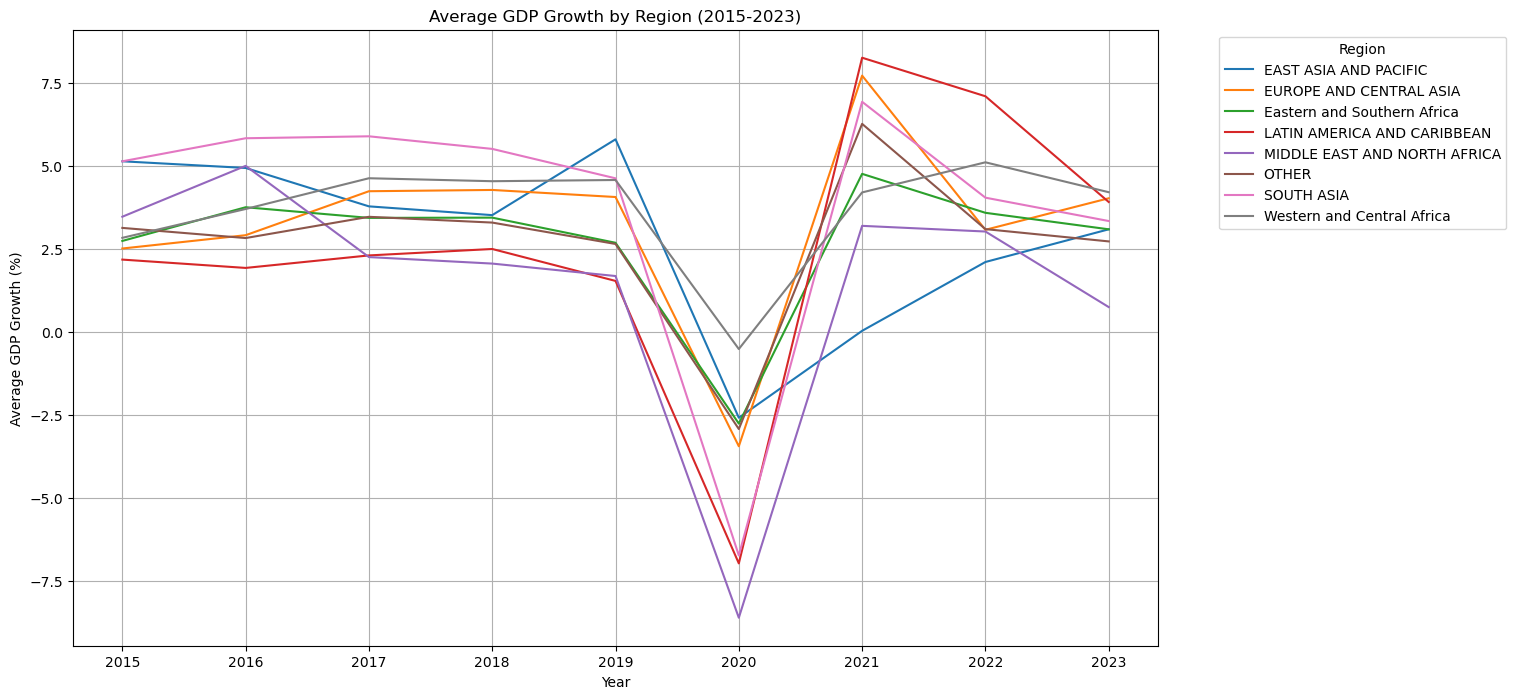

In [36]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Plot each region's GDP over the years
for region in region_gdp_avg['Region']:
    plt.plot(region_gdp_avg.columns[1:], region_gdp_avg[region_gdp_avg['Region'] == region].values[0][1:], label=region)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average GDP Growth (%)')
plt.title('Average GDP Growth by Region (2015-2023)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.show()